In [2]:
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
[test_set_raw, valid_set_raw, train_set_raw], info = tfds.load(
            "tf_flowers",
            split=["train[:10%]", "train[10%:25%]", "train[25%:]"], as_supervised=True,
            with_info=True)

In [3]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='~\\tensorflow_datasets\\tf_flowers\\3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [4]:
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples

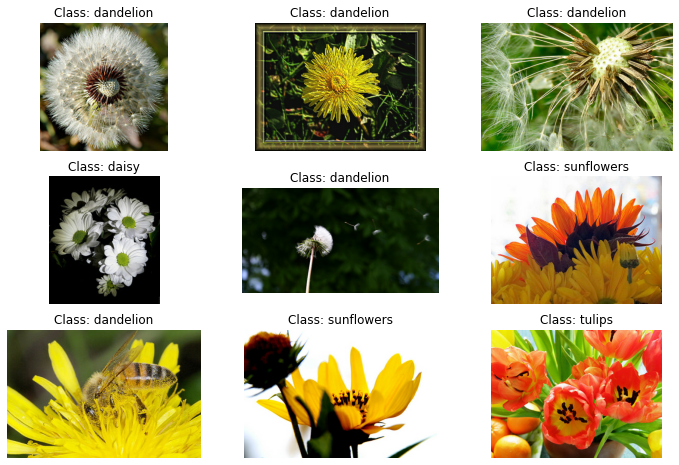

In [5]:
plt.figure(figsize=(12, 8))
index = 0
sample_images = train_set_raw.take(9) 
for image, label in sample_images:
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

#plt.show(block=False)

In [6]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224]) 
    return resized_image, label

In [7]:
batch_size = 32
train_set = train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1) 
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

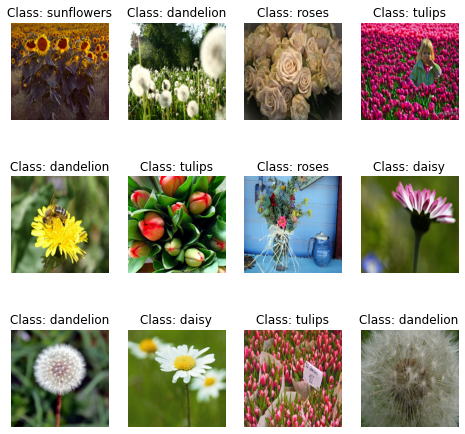

In [8]:
plt.figure(figsize=(8, 8)) 
sample_batch = train_set.take(1)
for X_batch, y_batch in sample_batch:
    for index in range(12):
        plt.subplot(3, 4, index + 1) 
        plt.imshow(X_batch[index]/255.0)
        plt.title("Class: {}".format(class_names[y_batch[index]])) 
        plt.axis("off")
#plt.show()

In [9]:
n_classes

5

In [10]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Rescaling(scale=1./127.5, offset=-1))
filters = [32, 40, 48, 56, 64]
size = [7, 6, 5, 4, 3]
for fil, ker_size in zip(filters, size):
    model.add(tf.keras.layers.Conv2D(filters=fil, kernel_size=ker_size, strides=1, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=2))
model.add(tf.keras.layers.Flatten())
neurons_number = [10, 30, 10]
for neuron in neurons_number:
    model.add(tf.keras.layers.Dense(neuron, activation='relu'))
model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

In [11]:
model.compile(metrics=['accuracy'], loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam')

In [12]:
model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 [==============================] - 142s 2s/step - loss: 1.6081 - accuracy: 0.2333 - val_loss: 1.6062 - val_accuracy: 0.2377
Epoch 2/10
86/86 [==============================] - 140s 2s/step - loss: 1.6040 - accuracy: 0.2402 - val_loss: 1.6041 - val_accuracy: 0.2377
Epoch 3/10
86/86 [==============================] - 144s 2s/step - loss: 1.6021 - accuracy: 0.2402 - val_loss: 1.6041 - val_accuracy: 0.2377
Epoch 4/10
86/86 [==============================] - 141s 2s/step - loss: 1.6014 - accuracy: 0.2402 - val_loss: 1.6028 - val_accuracy: 0.2377
Epoch 5/10
86/86 [==============================] - 139s 2s/step - loss: 1.6012 - accuracy: 0.2402 - val_loss: 1.6026 - val_accuracy: 0.2377
Epoch 6/10
86/86 [==============================] - 141s 2s/step - loss: 1.6011 - accuracy: 0.2402 - val_loss: 1.6023 - val_accuracy: 0.2377
Epoch 7/10
86/86 [==============================] - 140s 2s/step - loss: 1.6010 - accuracy: 0.2402 - val_loss: 1.6024 - val_accuracy: 0.2377
Epoch 8/10
86

In [13]:
train_value = model.evaluate(train_set)[1]

86/86 [==============================] - 24s 276ms/step - loss: 1.6007 - accuracy: 0.2402


In [14]:
test_value = model.evaluate(test_set)[1]

12/12 [==============================] - 3s 254ms/step - loss: 1.5948 - accuracy: 0.2888


In [15]:
valid_value = model.evaluate(valid_set)[1]

18/18 [==============================] - 5s 256ms/step - loss: 1.6024 - accuracy: 0.2377


In [16]:
values = (train_value, valid_value, test_value)
values

(0.24018895626068115, 0.23774954676628113, 0.2888283431529999)

In [17]:
import pickle

In [18]:
open_file = open("simple_cnn_acc.pkl", "wb")
pickle.dump(values, open_file)
open_file.close()

In [19]:
open_file = open("simple_cnn_acc.pkl", "rb")
loaded_list = pickle.load(open_file)
open_file.close()

print(loaded_list)

(0.24018895626068115, 0.23774954676628113, 0.2888283431529999)


In [20]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [21]:
train_set = train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1) 
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

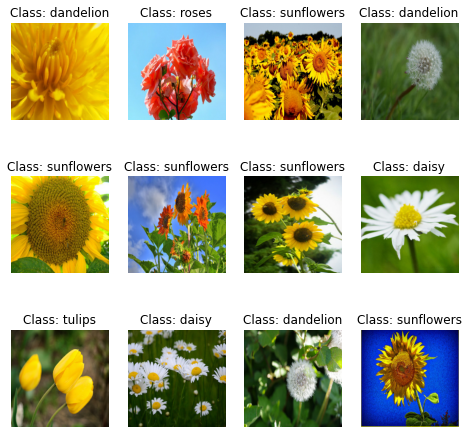

In [22]:
plt.figure(figsize=(8, 8))
sample_batch = train_set.take(1)
for X_batch, y_batch in sample_batch:
    for index in range(12):
        plt.subplot(3, 4, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")
#plt.show()


In [23]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)

In [24]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_5
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_6
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_7
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_a

In [25]:
gap_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output_layer = tf.keras.layers.Dense(n_classes, activation='softmax')(gap_layer)
model = tf.keras.Model(inputs=base_model.input, outputs=output_layer)

In [27]:
for layer in base_model.layers:
    layer.trainable = False
optimizer = tf.keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, nesterov=True, decay=0.01)
model.compile(loss=["sparse_categorical_crossentropy"], optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)
for layer in base_model.layers:
    layer.trainable = True
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, decay=0.001)
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/5
86/86 [==============================] - 121s 1s/step - loss: 0.1597 - accuracy: 0.9524 - val_loss: 0.7998 - val_accuracy: 0.8421
Epoch 2/5
86/86 [==============================] - 121s 1s/step - loss: 0.0768 - accuracy: 0.9731 - val_loss: 0.6177 - val_accuracy: 0.8766
Epoch 3/5
86/86 [==============================] - 111s 1s/step - loss: 0.0382 - accuracy: 0.9880 - val_loss: 0.6739 - val_accuracy: 0.8857
Epoch 4/5
86/86 [==============================] - 110s 1s/step - loss: 0.0254 - accuracy: 0.9945 - val_loss: 0.6765 - val_accuracy: 0.8766
Epoch 5/5
86/86 [==============================] - 109s 1s/step - loss: 0.0194 - accuracy: 0.9960 - val_loss: 0.6388 - val_accuracy: 0.8766
Epoch 1/10
86/86 [==============================] - 119s 1s/step - loss: 0.0148 - accuracy: 0.9975 - val_loss: 0.6612 - val_accuracy: 0.8784
Epoch 2/10
86/86 [==============================] - 117s 1s/step - loss: 0.0138 - accuracy: 0.9982 - val_loss: 0.6870 - val_accuracy: 0.8711
Epoch 3/10
86/86 [

In [28]:
train_ev = model.evaluate(train_set)[1]

86/86 [==============================] - 111s 1s/step - loss: 0.0087 - accuracy: 0.9996


In [29]:
valid_ev = model.evaluate(valid_set)[1]

18/18 [==============================] - 21s 1s/step - loss: 0.6418 - accuracy: 0.8784


In [30]:
test_ev = model.evaluate(test_set)[1]

12/12 [==============================] - 12s 1s/step - loss: 0.5598 - accuracy: 0.8856


In [31]:
tup_to_pickle = (train_ev, valid_ev, test_ev)

In [32]:
open_file = open("xception_acc.pkl", "wb")
pickle.dump(tup_to_pickle, open_file)
open_file.close()

In [33]:
open_file = open("xception_acc.pkl", "rb")
loaded_list = pickle.load(open_file)
open_file.close()

print(loaded_list)

(0.9996366500854492, 0.8784028887748718, 0.8855586051940918)
